## 1-Import essential packages and functions

we use `seaborn` and `matplotlib` to plot the figures

In [1]:
import math
import os
import sys
from dataclasses import dataclass
from itertools import cycle
from typing import Callable, Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn import metrics

sys.path.append(".")

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from algorithm.ScaleFC import flow_cluster_ScaleFC
from algorithm.util_tools import *  # noqa: E402, F403
from draw_flow import *  # noqa: E402, F403
from draw_flow import _my_color_map  # noqa: E402

sns.set_theme(style="ticks")

plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['axes.unicode_minus'] = False 

font_size = 7.2

# set fontsize globally
plt.rcParams.update({
    'font.size': font_size,         
    'axes.titlesize': font_size,    
    'axes.labelsize': font_size,    
    'xtick.labelsize': font_size,   
    'ytick.labelsize': font_size,   
    'legend.fontsize': font_size,   
    'figure.titlesize': font_size 
})

class ClusterExternalIndexAny:
    def __init__(self, real_lable, pred_label) -> None:
        self._real_label = np.asarray(real_lable, dtype=int)
        self._pred_label = np.asarray(pred_label, dtype=int)
        assert len(real_lable) == len(pred_label)
        assert len(real_lable) > 0

    @property
    def ARI(self):
        if np.all(self._pred_label == -1):
            return 0
        return metrics.adjusted_rand_score(self._real_label, self._pred_label)


@dataclass
class ODAlgorithmInfo:
    name: str  # name of the algorithm
    func: Callable
    other_func_kwargs: dict  # func(OD=OD, **func_kwargs)

# read all OD data
ODS = {}
Labels = {}
# 读取数据，存储在df中
for data_name in "ABCDEF":
    filepath = f'./data/Data{data_name}.txt'
    labelpath = f'./data/Data{data_name}-label.txt'
    OD = np.loadtxt(filepath, delimiter=',')
    real_label = np.loadtxt(labelpath, delimiter=',', dtype=int)
    ODS[data_name] = OD
    Labels[data_name] = real_label
    ODS[f"Dataset {data_name}"] = OD
    Labels[f"Dataset {data_name}"] = real_label
    
    


## 2-Draw six dataset

The first step is to draw the six synthetic datasets and show details in the insets.

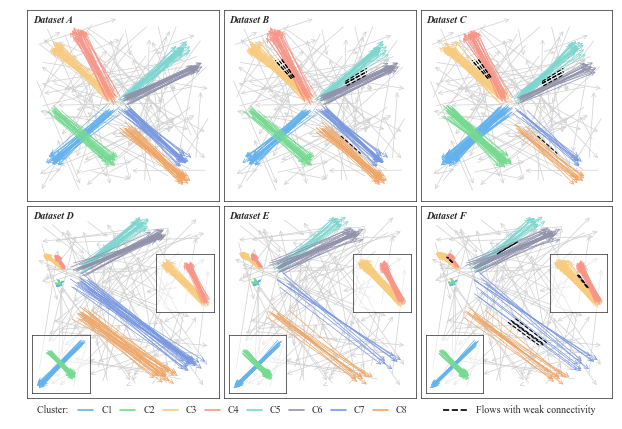

In [ ]:
basic_inch = 1.94 # 不建议再继续增大了，这里的单位是英寸
row_num = 2 # 行数
col_num = 3 # 列数
assert row_num * col_num == 6
# 直接绘制6个数据集
names = "ABCDEF"
# 创建一个空的 DataFrame
df = pd.DataFrame(columns=['Name', 'OD', 'Label'])
# 读取数据，存储在df中
for name in ODS.keys():
    if name.startswith("Dataset"):
        df.loc[len(df)] = [name, ODS[name], Labels[name]]

# fig, axs = plt.subplots(row_num, col_num, figsize=(basic_inch * col_num, basic_inch * (row_num+0)))  # 改为2x3布局
figs, axsize = get_figsize_and_axes_sizeinfo(2, 3,  bottom_margin=0)
fig, axs = get_fig_and_axes_from_sizeinfo(figs, axsize)
axs = np.reshape(axs,(row_num, col_num))
# 这个循环里面绘制所有的数据集
for index, row in df.iterrows():
    # if index != 3: continue
    OD = row["OD"]
    title = row["Name"]
    real_label = row["Label"]
    cur_ax = axs[index // col_num, index % col_num]
    flow_draw_cluster_with_labels(OD, real_label, color_generator='feature', title="", new_color_gen=True, ax=cur_ax, lw=0.5, noise_flow_color="#d0d0d0")  # 调整索引以适应2x3布局
    # cur_ax.set_title(title, fontweight='bold', fontstyle='italic')
    # cur_ax.set_title('')
    cur_ax.text(0.03, 0.97, title, transform=cur_ax.transAxes, ha='left', va='top', fontweight='bold', fontstyle='italic')
    # 把标题放在ax的左上角

    
    # 添加图例
    if index == 0:
        curgen = cycle(_my_color_map["feature"])
        legend_handles = [Line2D([0], [0], color=next(curgen), lw=1.2, label=f"C{i+1}") for i in range(8)]
        # 仅给图1添加标签
        # cur_ax.text(x=1, y=1, s='C1')
        # cur_ax.text(x=1, y=14, s='C2')
        # cur_ax.text(x=1, y=35, s='C3')
        # cur_ax.text(x=14, y=34, s='C4')
        # cur_ax.text(x=30, y=30, s='C5')
        # cur_ax.text(x=35, y=25, s='C6')
        # cur_ax.text(x=38, y=5, s='C7')
        # cur_ax.text(x=28, y=1, s='C8')


    if index in (1, 2, 5): # B的弱连接
        if index == 5:
            num = -9
        else:
            num = -11
        indices = np.arange(num, 0, dtype=int)
        
        # print(indices.shape)
        newOD = OD[indices]
        newLabel = real_label[indices]
        # fig, ax = flow_draw(newOD, color='red')
        newOD = flow_zoom_out(newOD, 0.7)  # noqa: F405

        # 提取起点和终点的坐标
        x_coords = newOD[:, [0, 2]]
        y_coords = newOD[:, [1, 3]]

        # 创建一个绘图
        # 绘制弱连接的部分
        cur_ax.plot(x_coords.T, y_coords.T, color="black", linestyle="--",zorder=9, lw=0.8,)
        
        # legend_handles.append(custom_line)
        # break
    elif index == 5:
        pass

    if index > 2:
        # 绘制短的
        curg = cycle(_my_color_map["feature"])
        next(curg)
        next(curg)
        new_ax = inset_axes(cur_ax, width="30%", height="30%", loc='center right',bbox_to_anchor=(0., 0.1, 1, 1), bbox_transform=cur_ax.transAxes)
        indices = np.where((real_label == 2) | (real_label == 3))[0]
        newOD = OD[indices]
        flow_draw_cluster_with_labels(newOD, real_label[indices], color_generator=curg, title="", new_color_gen=False, ax=new_ax, lw=0.5, noise_flow_color="#d0d0d0")  # 调整索引以适应2x3布局
        new_ax.patch.set_alpha(0.5) # 设置透明
        for spine in new_ax.spines.values():
            spine.set_linewidth(0.5)  #粗细，可以根据需要调整

        if index == 5: # 小图里面也要画
            newOD2 = newOD[-3:]
            # fig, ax = flow_draw(newOD, color='red')
            newOD2 = flow_zoom_out(newOD2, 0.7)

            # 提取起点和终点的坐标
            x_coords = newOD2[:, [0, 2]]
            y_coords = newOD2[:, [1, 3]]

            # 创建一个绘图
            # 使用批量绘图的方法绘制所有的线段
            new_ax.plot(x_coords.T, y_coords.T, color="black", zorder=9, linestyle="--", lw=0.8,)
        
 
        new_ax = inset_axes(cur_ax, width="30%", height="30%", loc='lower left')
        indices = np.where((real_label == 0) | (real_label == 1))[0]
        newOD = OD[indices]
        flow_draw_cluster_with_labels(newOD, real_label[indices], color_generator='feature', title="", new_color_gen=True, ax=new_ax, lw=0.5, noise_flow_color="#d0d0d0")  # 调整索引以适应2x3布局
        for spine in new_ax.spines.values():
            spine.set_linewidth(0.5)  #粗细，可以根据需要调整
            
        new_ax.patch.set_alpha(0.5) # 设置透明

    for spine in cur_ax.spines.values():
        spine.set_linewidth(0.5)  #粗细，可以根据需要调整


# handles, labels = axs[0, 0].get_legend_handles_labels()
custom_line = Line2D([0], [0], color='black', linestyle="--", lw=1.2, label='Flows with weak connectivity')
# 在整个图形的最上方放置图例
first_legend = fig.legend(handles=[plt.Line2D([0], [0], color='w', lw=0, marker=' ', markersize=0, label='Cluster: ')] + legend_handles, loc='center', 
                          ncol=9, bbox_to_anchor=(0.32, -0.03),frameon=False,
                          labelspacing=0.5,  # 缩小标签之间的间距
                        #   borderpad=0.5,     # 减少图例框内的边距
                          handlelength=1.5,    # 缩短线条的长度
                        #   handleheight=1,    # 控制线条高度
                          columnspacing=0.75)    # 控制列之间的间距)
sec_legend = fig.legend(handles=[custom_line], loc='center', 
                          ncol=9, bbox_to_anchor=(0.83, -0.03), frameon=False,
                          labelspacing=0.5,  # 缩小标签之间的间距
                        #   borderpad=0.5,     # 减少图例框内的边距
                          handlelength=2.5,    # 缩短线条的长度
                        #   handleheight=1,    # 控制线条高度
                          columnspacing=0.75)    # 控制列之间的间距)
# fig.add_artist(first_legend)
plt.tight_layout()
# fig.savefig("Fig/Fig6.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig6.svg", bbox_inches='tight')
plt.show()


## 3-Draw clustering results
In this section, we draw the clustering results of four algorithms, i.e.g, AFC, FlowLF, FlowDBSCAN, and ScaleFC on six synthetic datasets.

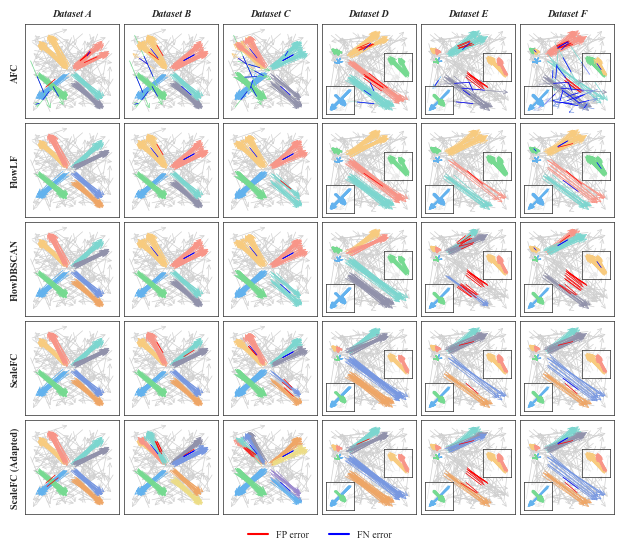

In [3]:
def get_fig_and_axes(row_num, col_num, A4_width=6.05):
    # 整个大图的边缘
    left_margin = 0.08
    right_margin = 0.08
    bottom_margin = 0.08
    top_margin = 0.15

    twofigs_margin = 0.05

    # 8.27是A4的宽度，单位英寸
    sf_size = (A4_width - right_margin - left_margin - twofigs_margin * (col_num - 1)) / col_num
    sf_size = math.floor(sf_size * 100) / 100

    figsize = (left_margin + right_margin + col_num * sf_size + (col_num - 1) * twofigs_margin, 
            row_num * sf_size + bottom_margin + top_margin + (row_num - 1) * twofigs_margin)


    # 根据0,0计算出坐标的大小
    func = lambda a, b: ((left_margin + b * (sf_size + twofigs_margin))/figsize[0],  # noqa: E731
                (bottom_margin + (row_num - 1 - a) * (sf_size + twofigs_margin))/ figsize[1], 
                sf_size / figsize[0] ,
                sf_size / figsize[1])

    # 创建数组
    # print(figsize)
    axes = np.empty((row_num, col_num), dtype=object)
    fig = plt.figure(figsize=figsize)
    for a in range(row_num):
        for b in range(col_num):
            cur_ax = fig.add_axes(func(a, b))
            # cur_ax.scatter(0, 0)
            axes[a, b] = cur_ax
            for spine in cur_ax.spines.values():
                spine.set_linewidth(0.5)  # 粗细，可以根据需要调整 

    return fig, axes


def str_to_array(s):
    import re
    return np.array([int(x) for x in re.findall(r'-?\d+', s)])
df = pd.read_csv('result/synthetic_clustering_resuls.csv', converters={'RealLabel': str_to_array, 'PredLabel': str_to_array})

newrow_num = 5
newcol_num = 6
fig, axs = get_fig_and_axes(newrow_num, newcol_num)

# 确保数据量不超过图的容量
data_df = df.iloc[:newrow_num * newcol_num]

index = -1
for _, row in data_df.iterrows():
    index += 1
    name = row['DataName'].split()[1]
    OD = ODS[name]
    pred_label = row["PredLabel"]
    real_label = row["RealLabel"]
    cur_ax = axs[index % newrow_num, index // newrow_num]
    inset = False
    if row["DataName"] in ("Dataset D", "Dataset E", "Dataset F"):
        inset = True
    flow_draw_cluster_fp_fn_error_by_lines2(
        OD, real_label, pred_label,
        draw_cluster_with_label_kwargs=dict(color_generator='feature', title="", new_color_gen=True, ax=cur_ax, lw=0.5, noise_flow_color="#d0d0d0"),
        fn_line_kwargs={'color': 'red', 'zorder': 9, "lw": 0.5},
        fp_line_kwargs={'color': 'blue', 'zorder': 9, "lw": 0.5},
        draw_inset=inset
    )
    
    if index % newrow_num == 0:
        cur_ax.set_title(row['DataName'], fontweight='bold', fontstyle='italic')
    if index // newrow_num == 0:
        cur_ax.set_ylabel(row['AlgoName'], fontweight='bold')
    
    for spine in cur_ax.spines.values():
        spine.set_linewidth(0.5)  # 粗细，可以根据需要调整

# 单独处理图例
legend_handles = [
    Line2D([0], [0], color="red", lw=1.5, label="FP error"),
    Line2D([0], [0], color="blue", lw=1.5, label="FN error")
]
fig.legend(handles=legend_handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
# fig.savefig("Fig/Fig7.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig7.svg", bbox_inches='tight')
plt.show()

## 4-Draw fixed and dynamic neighborhood figures
In this section, we draw clustering results about ScaleFC using fixed neighborhood and dynamic neighborhood.

In [4]:
def run_cluster(OD, od_algo_info):
    func = od_algo_info.func
    other_func_kwargs = od_algo_info.other_func_kwargs
    return func(OD=OD, **other_func_kwargs)

# 返回figsize和每个axes的尺寸信息，即x,y, width, height
def get_axes_size_info(row_num=4, col_num=6, A4_width=6.05, height_width_ratio=1, 
                        left_margin = 0.1,
                        right_margin = 0.1,
                        bottom_margin = 0.1,
                        top_margin = 0.15,
                        twofigs_width_margin = 0.05,
                        twofigs_height_margin = 0.05):
    # 整个大图的边缘
    #单位英寸
    width_size = (A4_width - right_margin - left_margin - twofigs_width_margin * (col_num - 1)) / col_num
    height_size = width_size * height_width_ratio
    # print(sf_size)

    figsize = (left_margin + right_margin + col_num * width_size + (col_num - 1) * twofigs_width_margin, 
            row_num * height_size + bottom_margin + top_margin + (row_num - 1) * twofigs_height_margin)


    # 根据0,0计算出坐标的大小
    func = lambda a, b: ((left_margin + b * (width_size + twofigs_width_margin))/figsize[0], 
                (bottom_margin + (row_num - 1 - a) * (height_size + twofigs_height_margin))/ figsize[1], 
                width_size / figsize[0] ,
                height_size / figsize[1])

    # 创建数组
    # print(figsize)
    size_info = np.empty((row_num, col_num), dtype=object)
    for a in range(row_num):
        for b in range(col_num):
            size_info[a, b] = func(a, b)

    return (figsize, size_info)


def get_fig_and_axes(row_num=4, col_num=6, A4_width=6.05, height_width_ratio=1, 
                        left_margin = 0.1,
                        right_margin = 0.1,
                        bottom_margin = 0.1,
                        top_margin = 0.15,
                        twofigs_width_margin = 0.05,
                        twofigs_height_margin = 0.05):
    # 整个大图的边缘
    #单位英寸
    width_size = (A4_width - right_margin - left_margin - twofigs_width_margin * (col_num - 1)) / col_num
    height_size = width_size * height_width_ratio
    # print(sf_size)

    figsize = (left_margin + right_margin + col_num * width_size + (col_num - 1) * twofigs_width_margin, 
            row_num * height_size + bottom_margin + top_margin + (row_num - 1) * twofigs_height_margin)


    # 根据0,0计算出坐标的大小
    func = lambda a, b: ((left_margin + b * (width_size + twofigs_width_margin))/figsize[0], 
                (bottom_margin + (row_num - 1 - a) * (height_size + twofigs_height_margin))/ figsize[1], 
                width_size / figsize[0] ,
                height_size / figsize[1])

    # 创建数组
    # print(figsize)
    axes = np.empty((row_num, col_num), dtype=object)
    fig = plt.figure(figsize=figsize)
    for a in range(row_num):
        for b in range(col_num):
            cur_ax = fig.add_axes(func(a, b))
            axes[a, b] = cur_ax
            for spine in cur_ax.spines.values():
                spine.set_linewidth(0.5)  # 粗细，可以根据需要调整 

    return fig, axes


def get_fig_from_sizeinfo(figsize, *sizeinfo: np.ndarray):
    fig = plt.figure(figsize=figsize)
    axes = []
    flattened_arrays = np.concatenate([np.ravel(arr) for arr in sizeinfo])
    for x in flattened_arrays:
        # print(x)
        cur_ax = fig.add_axes(x)
        axes.append(cur_ax)
        for spine in cur_ax.spines.values():
            spine.set_linewidth(0.5)  # 粗细，可以根据需要调整 
    
    return fig, axes


# 返回的也是figsize，以及每个ax的sizeinfo
def fig_vstack(figsize1, figsize2, axs1_sizeinfo: np.ndarray, axs2_sizeinfo: np.ndarray):
    fig1_width, fig1_height = figsize1
    fig2_width, fig2_height = figsize2
    total_width = max(fig1_width, fig2_width)
    total_height = fig1_height + fig2_height
    
    N, M = axs1_sizeinfo.shape
    for i in range(N):
        for j in range(M):
            x, y, w, h = axs1_sizeinfo[i, j]
            x = x * fig1_width / total_width
            y = (y * fig1_height + fig2_height) / total_height
            w = w * fig1_width / total_width
            h = h * fig1_height / total_height
            axs1_sizeinfo[i, j] = (x, y, w, h)
    
    N, M = axs2_sizeinfo.shape
    for i in range(N):
        for j in range(M):
            x, y, w, h = axs2_sizeinfo[i, j]
            x = x * fig2_width / total_width
            y = y * fig2_height / total_height
            w = w * fig2_width / total_width
            h = h * fig2_height / total_height
            axs2_sizeinfo[i, j] = (x,y, w, h)
    return ((total_width, total_height), axs1_sizeinfo, axs2_sizeinfo)


def fig_hstack(figsize1, figsize2, axs1_sizeinfo: np.ndarray, axs2_sizeinfo: np.ndarray):
    fig1_width, fig1_height = figsize1
    fig2_width, fig2_height = figsize2
    total_width = fig1_width + fig2_width
    total_height = max(fig1_height, fig2_height)
    
    N, M = axs1_sizeinfo.shape
    for i in range(N):
        for j in range(M):
            x, y, w, h = axs1_sizeinfo[i, j]
            x = x * fig1_width / total_width
            y = y * fig1_height / total_height
            w = w * fig1_width / total_width
            h = h * fig1_height / total_height
            axs1_sizeinfo[i, j] = (x, y, w, h)
    
    N, M = axs2_sizeinfo.shape
    for i in range(N):
        for j in range(M):
            x, y, w, h = axs2_sizeinfo[i, j]
            x = (x * fig2_width + fig1_width) / total_width
            y = y * fig2_height / total_height
            w = w * fig2_width / total_width
            h = h * fig2_height / total_height
            axs2_sizeinfo[i, j] = (x,y, w, h)
    return ((total_width, total_height), axs1_sizeinfo, axs2_sizeinfo)


def draw_each_fig(df, ax, labelname: str, dataset_name: str):
    sub_df = df[df['Dataset'] == dataset_name]
    OD = sub_df.iloc[0]['OD']
    real_label = sub_df.iloc[0]['RealLabel']
    curlabel = sub_df.iloc[0][labelname]
    # print(curlabel)
    if dataset_name in ("Dataset D", "Dataset E", "Dataset F"):
        inset = True
    else:
        inset = False
    flow_draw_cluster_fp_fn_error_by_lines2(OD, real_label, curlabel, draw_cluster_with_label_kwargs=dict(color_generator='feature', title="", new_color_gen=True, ax=ax, lw=0.5, noise_flow_color="#d0d0d0"), fn_line_kwargs = {'color': 'red', 'zorder': 9, "lw": 0.5}, fp_line_kwargs = {'color': 'blue', 'zorder': 9, "lw": 0.5}, draw_inset=inset)

def draw_each_fig_lines(df, ax, ylst: list, has_ytickslabel=False):
    desired_order = ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D', 'Dataset E', 'Dataset F']
    for y in ylst:
        sns.lineplot(ax=ax, data=df, x="Dataset", y=y, marker="o", markersize=3, lw=1)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(range(len(desired_order)))  # 强制设置x轴的刻度
    ax.set_xticklabels(list("ABCDEF"), fontweight='bold', fontstyle='italic') # 强制设置x轴的标签
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0.0,0.5,1.0])
    if has_ytickslabel:
        ax.set_yticklabels(['0','0.5','1.0'])
    else:
        ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', width=.5, length=1.5, labelsize=7.2)
    # ax.set_title(title, fontsize=8, )


In [5]:

# 加载6个数据集，计算最大、最小、平均、最好的搜索邻域
min_eps = []
max_esp = []
mean_eps = []
ODs = []
labels = []
for name, mf in zip("ABCDEF", [4, 9, 5, 5, 5, 5]):
    filepath = f'./data/Data{name}.txt'
    labelpath = f'./data/Data{name}-label.txt'

    OD = np.loadtxt(filepath, delimiter=',')
    real_label = np.loadtxt(labelpath, delimiter=',', dtype=int)
    
    res = flow_kth_nearest_neighbor_distance(OD[real_label != -1], k=mf)
    print(f"Dataset {name}, min k-dist: {res.min():.3f}, max k-dist: {res.max():.3f}, mean k-dist: {res.mean():.3f}")
    min_eps.append(res.min())
    max_esp.append(res.max())
    mean_eps.append(res.mean())
    ODs.append(OD) 
    labels.append(real_label)


scale_factor_lst = [0.2, 0.2, 0.19, 0.24, 0.23, 0.21]
other_kwargs = [
dict(min_flows=4, n_jobs=-1, can_discard_flow_group_func=lambda x,y :len(x) < 8), 
dict(min_flows=9, n_jobs=-1), 
dict(min_flows=5, n_jobs=-1), 
dict(min_flows=5, n_jobs=-1), 
dict(min_flows=5, n_jobs=-1, can_discard_flow_group_func=lambda x,y :len(x) < 8), 
dict(min_flows=5, n_jobs=-1, can_discard_flow_group_func=lambda x, y :len(x) < 8)
]

best_fix_params, min_fixed_params, max_fixed_params, mean_fixed_params, scale_factor_params = [], [], [], [], []

# 内部函数，计算每个 eps 对应的 ARI
def compute_ari_for_eps(OD, label, eps, cur_kwargs):
    predlabel = flow_cluster_ScaleFC(OD, eps=eps, **cur_kwargs)
    ari = ClusterExternalIndexAny(label, predlabel).ARI
    return ari, eps

# 寻找每个 OD 和 label 的最优 eps
def find_best_eps(OD, label, cur_kwargs):
    # 使用并行来加速 eps 搜索
    results = Parallel(n_jobs=-1)(delayed(compute_ari_for_eps)(OD, label, eps, cur_kwargs) for eps in np.arange(1, 10, 0.01))
    
    # 找到具有最大 ARI 的 eps
    max_ari, best_eps = max(results, key=lambda x: x[0])
    print(f"Best eps for dataset {i}: {best_eps:.3f}, {max_ari:.3f}")
    return best_eps

# 使用 joblib 并行处理外层循环，每个 scale_factor_lst 的元素
# 需要寻找的话，请取消下面的注释
# best_eps_list = Parallel(n_jobs=-1)(delayed(find_best_eps)(ODs[i], labels[i], other_kwargs[i]) for i in range(len(scale_factor_lst)))
# print(best_eps_list)
best_eps_list = [2.080000000000001, 2.220000000000001, 2.6600000000000015, 5.300000000000004, 1.2400000000000002, 1.3900000000000003]

for i in range(len(scale_factor_lst)):
    cur_kwargs = other_kwargs[i]
    kw = cur_kwargs.copy()
    kw["eps"] = best_eps_list[i]
    p1 = ODAlgorithmInfo(name="ScaleFC", other_func_kwargs=kw, func=flow_cluster_ScaleFC)
    best_fix_params.append(p1)
    
    kw = cur_kwargs.copy()
    kw["eps"] = min_eps[i]
    p2 = ODAlgorithmInfo(name="ScaleFC", other_func_kwargs=kw, func=flow_cluster_ScaleFC)
    min_fixed_params.append(p2)
    
    kw = cur_kwargs.copy()
    kw["eps"] = max_esp[i]
    p3 = ODAlgorithmInfo(name="ScaleFC", other_func_kwargs=kw, func=flow_cluster_ScaleFC)
    max_fixed_params.append(p3)
    
    kw = cur_kwargs.copy()
    kw["eps"] = mean_eps[i]
    p4 = ODAlgorithmInfo(name="ScaleFC", other_func_kwargs=kw, func=flow_cluster_ScaleFC)
    mean_fixed_params.append(p4)
    
    kw = cur_kwargs.copy()
    kw["scale_factor"] = scale_factor_lst[i]
    p4 = ODAlgorithmInfo(name="ScaleFC", other_func_kwargs=kw, func=flow_cluster_ScaleFC)
    scale_factor_params.append(p4)
    
# print(best_fix_params, min_fixed_params, max_fixed_params, mean_fixed_params, scale_factor_params )

# 6个数据集的固定搜索邻域与非固定搜索邻域的差异
# 以下为每个数据集的采用尺度因子的设置情况

df  = pd.DataFrame(columns=["Dataset", 
                            "BestFixedARI", "MaxFixedARI", "MeanFixedARI","DynamicARI", 
                            "C12BestFixedARI", "C12MaxFixedARI", "C12MeanFixedARI","C12DynamicARI", 
                            "C34BestFixedARI", "C34MaxFixedARI", "C34MeanFixedARI","C34DynamicARI", 
                            "C56BestFixedARI", "C56MaxFixedARI", "C56MeanFixedARI","C56DynamicARI", 
                            "C78BestFixedARI", "C78MaxFixedARI", "C78MeanFixedARI","C78DynamicARI", 
                            "BestFixedLabel", "MaxFixedLabel", "MeanFixedLabel", "DynamicLabel",
                            "OD", "RealLabel",])
for name, best, maxf, meanf, sf in zip("ABCDEF", best_fix_params, max_fixed_params, mean_fixed_params, scale_factor_params):
    filepath = f'./data/Data{name}.txt'
    labelpath = f'./data/Data{name}-label.txt'

    OD = np.loadtxt(filepath, delimiter=',')
    real_label = np.loadtxt(labelpath, delimiter=',', dtype=int)
    
    best_label = run_cluster(OD, best)
    maxf_label = run_cluster(OD, maxf)
    mean_label = run_cluster(OD, meanf)
    dymaic_label = run_cluster(OD, sf)
    
    idx12 = np.where((real_label == 0) | (real_label == 1))[0]
    idx34 = np.where((real_label == 2) | (real_label == 3))[0]
    idx56 = np.where((real_label == 4) | (real_label == 5))[0]
    idx78 = np.where((real_label == 6) | (real_label == 7))[0]
    
    df.loc[len(df)] = [f"Dataset {name}", 
                       ClusterExternalIndexAny(best_label,   real_label).ARI, 
                       ClusterExternalIndexAny(maxf_label,   real_label).ARI, 
                       ClusterExternalIndexAny(mean_label,   real_label).ARI, 
                       ClusterExternalIndexAny(dymaic_label, real_label).ARI, 
                        ClusterExternalIndexAny(best_label[idx12],   real_label[idx12]).ARI,
                        ClusterExternalIndexAny(maxf_label[idx12],   real_label[idx12]).ARI,
                        ClusterExternalIndexAny(mean_label[idx12],   real_label[idx12]).ARI,
                        ClusterExternalIndexAny(dymaic_label[idx12], real_label[idx12]).ARI,
                        ClusterExternalIndexAny(best_label[idx34],   real_label[idx34]).ARI,
                        ClusterExternalIndexAny(maxf_label[idx34],   real_label[idx34]).ARI,
                        ClusterExternalIndexAny(mean_label[idx34],   real_label[idx34]).ARI,
                        ClusterExternalIndexAny(dymaic_label[idx34], real_label[idx34]).ARI,
                        ClusterExternalIndexAny(best_label[idx56],   real_label[idx56]).ARI,
                        ClusterExternalIndexAny(maxf_label[idx56],   real_label[idx56]).ARI,
                        ClusterExternalIndexAny(mean_label[idx56],   real_label[idx56]).ARI,
                        ClusterExternalIndexAny(dymaic_label[idx56], real_label[idx56]).ARI,
                        ClusterExternalIndexAny(best_label[idx78],   real_label[idx78]).ARI,
                        ClusterExternalIndexAny(maxf_label[idx78],   real_label[idx78]).ARI,
                        ClusterExternalIndexAny(mean_label[idx78],   real_label[idx78]).ARI,
                        ClusterExternalIndexAny(dymaic_label[idx78], real_label[idx78]).ARI,
                       best_label, 
                        maxf_label,
                        mean_label,
                        dymaic_label,
                        OD, real_label]


Dataset A, min k-dist: 0.586, max k-dist: 2.135, mean k-dist: 1.252
Dataset B, min k-dist: 0.848, max k-dist: 2.814, mean k-dist: 1.590
Dataset C, min k-dist: 0.718, max k-dist: 2.624, mean k-dist: 1.403
Dataset D, min k-dist: 0.141, max k-dist: 5.587, mean k-dist: 2.004
Dataset E, min k-dist: 0.142, max k-dist: 7.633, mean k-dist: 1.573
Dataset F, min k-dist: 0.142, max k-dist: 8.279, mean k-dist: 1.701


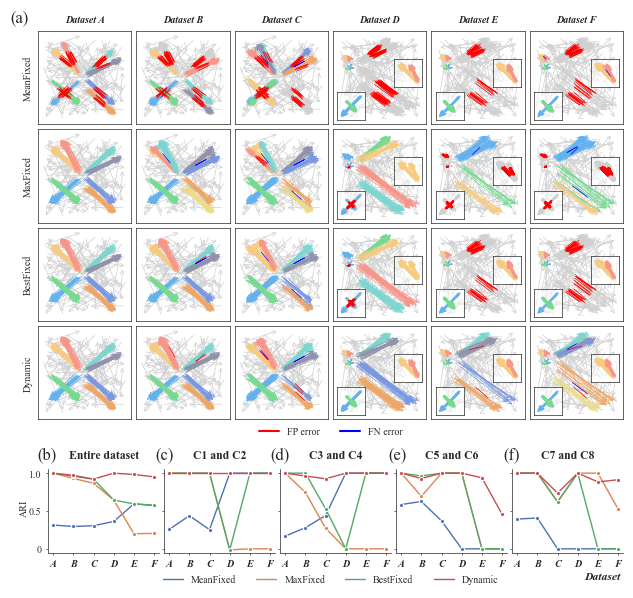

In [6]:
figsize1, sizeinfo1 = get_axes_size_info(4, 6)
figsize2, sizeinfo2 = get_axes_size_info(1, 5, left_margin=0.2, height_width_ratio=0.75, twofigs_width_margin=0.05, top_margin=0.4)

figsize, axes1, axes2 = fig_vstack(figsize1, figsize2, sizeinfo1, sizeinfo2)

fig, axes = get_fig_from_sizeinfo(figsize, axes1, axes2)
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
axes1 = axes[:24]
axes2 = axes[24:]

labelnames = np.ravel(["MeanFixedLabel"]*6 + ["MaxFixedLabel"]*6+ ["BestFixedLabel"]*6+["DynamicLabel"]*6)
# labelnames
datanames = np.ravel(["Dataset A"]*5 + ["Dataset B"]*5 + ["Dataset C"]*5 + ["Dataset D"]*5+["Dataset E"]*5+["Dataset F"]*5)
datanames = datanames.reshape(-1, 5).T.flatten()

c1= 0
ylabels = ["MeanFixed", "MaxFixed", "BestFixed", "Dynamic"]
for i in range(len(labelnames)):
    draw_each_fig(df, axes[i], labelnames[i], datanames[i])
    if i % 6 == 0:
        axes1[i].set_ylabel(ylabels[c1], fontsize=7.2)
        c1 += 1
    if i < 6:
        axes1[i].set_title(datanames[i], fontsize=7.2, fontweight='bold', fontstyle='italic')

draw_each_fig_lines(df, axes2[0], ["MeanFixedARI", "MaxFixedARI", "BestFixedARI", "DynamicARI"], has_ytickslabel=True)
draw_each_fig_lines(df, axes2[1], ["C12MeanFixedARI", "C12MaxFixedARI", "C12BestFixedARI", "C12DynamicARI"])
draw_each_fig_lines(df, axes2[2], ["C34MeanFixedARI", "C34MaxFixedARI", "C34BestFixedARI", "C34DynamicARI"])
draw_each_fig_lines(df, axes2[3], ["C56MeanFixedARI", "C56MaxFixedARI", "C56BestFixedARI", "C56DynamicARI"])
draw_each_fig_lines(df, axes2[4], ["C78MeanFixedARI", "C78MaxFixedARI", "C78BestFixedARI", "C78DynamicARI"])

fig.text(-0.03, 0.99, "(a)", fontsize=12)
fig.text(0.015, 0.19, "(b)", fontsize=12)
fig.text(0.21,  0.19, "(c)", fontsize=12)
fig.text(0.40,  0.19, "(d)", fontsize=12)
fig.text(0.595,  0.19, "(e)", fontsize=12)
fig.text(0.785,  0.19, "(f)", fontsize=12)
fig.text(0.92, -0.03, "Dataset", fontweight='bold', fontstyle='italic', fontsize=8.4)

# fig.text(0.05, 0.19, "Entire dataset",      fontsize=8.4)
# fig.text(0.245,  0.19, "C1 and C2",         fontsize=8.4)
# fig.text(0.437,  0.19, "C3 and C4",         fontsize=8.4)
# fig.text(0.595+0.035,  0.19, "C5 and C6",   fontsize=8.4)
# fig.text(0.785+0.035,  0.19, "C7 and C8",   fontsize=8.4)
axes2[0].set_title("Entire dataset", fontsize=8.4, fontweight='bold', pad=8)
axes2[1].set_title("C1 and C2", fontsize=8.4, fontweight='bold', pad=8)
axes2[2].set_title("C3 and C4", fontsize=8.4, fontweight='bold', pad=8)
axes2[3].set_title("C5 and C6", fontsize=8.4, fontweight='bold', pad=8)
axes2[4].set_title("C7 and C8", fontsize=8.4, fontweight='bold', pad=8)

fig.text(-0.015, 0.088, "ARI",rotation=90,  fontsize=7.2)
co = sns.color_palette()[:len(ylabels)]
legend_handles = [Line2D([0], [0], color=co[i], lw=1, label=ylabels[i]) for i in range(len(co))]
fig.legend(handles=legend_handles, loc='center', ncol=4, bbox_to_anchor=(0.5, -0.03), frameon=False, )
legend_handles = [
    Line2D([0], [0], color="red", lw=1.5, label="FP error"),
    Line2D([0], [0], color="blue", lw=1.5, label="FN error")
]
fig.legend(handles=legend_handles, loc='center', ncol=2, bbox_to_anchor=(0.5, 0.24), frameon=False)
plt.tight_layout()
# fig.savefig("Fig/Fig8.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig8.svg", bbox_inches='tight')
plt.show()

## 5-Draw the impact of scale factor and MinFlows

This section discuss the impact of the two parameters of ScaleFC: scale factor and MinFlows

In [2]:
pd.options.mode.chained_assignment = None
# 读取数据
df = pd.read_csv('./result/impact_of_two_parameters.csv')

def draw_heatmap(df, ax, datasetname, ARI_label='', xtickslabel=True, ytickslabel=True):
    dff = df[df['Dataset'] == datasetname]
    # 创建二维透视表
    pivot_table = dff.pivot(index="K", columns="SF", values="ARI")
    
    # 绘制热图
    # ax = sns.heatmap(pivot_table, cmap="viridis_r", cbar_kws={'label': ARI_label, "pad":0.01}, ax=ax)
    ax = sns.heatmap(pivot_table, cmap="viridis_r", cbar=False, ax=ax)
    ax.invert_yaxis()
    # cbar = ax.collections[0].colorbar
    # cbar_ax = cbar.ax
    # # 对 cbar 进行操作，例如更改标签字体大小
    # cbar_ax.tick_params(width=.5, length=1.5)
    # 限制横轴和纵轴显示的刻度数量为 10 个
    ax.set_xticks(np.linspace(0, len(pivot_table.columns) - 1, 10).astype(int), 
            np.round(pivot_table.columns[np.linspace(0, len(pivot_table.columns) - 1, 10).astype(int)], 2))

    ax.set_yticks(np.linspace(0, len(pivot_table.index) - 1, 10).astype(int), 
            pivot_table.index[np.linspace(0, len(pivot_table.index) - 1, 10).astype(int)])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='both', width=.5, length=1.5,)
    # 设置标题
    ax.set_title(f"{datasetname}", fontweight='bold', fontstyle='italic', pad=3)
    if not xtickslabel:
        ax.set_xticklabels([])
    if not ytickslabel:
        ax.set_yticklabels([])


def draw_scale_factor_sensitivity(df, ax, datasetname, minflow: int):
    ddf = df[(df["Dataset"] == datasetname) & (df['K'] == minflow)]
    ddf['ARI'] = ddf['ARI'].round(2)
    ax.tick_params(axis='both', width=.5, length=1.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.set_title(f"{datasetname}", fontweight='bold', fontstyle='italic')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 0.5])
    
    ddf['SF'] = ddf['SF'].round(2)
    # 找到 ARI 的最大值
    max_ari = 0.9
    # 筛选出 ARI 等于最大值的行
    max_ari_rows = ddf[ddf['ARI'] >= max_ari]
    # 确保 SF 列是连续的，找到 SF 区间
    # 找到 SF 的最小和最大值
    left_sf = max_ari_rows['SF'].min()
    right_sf = max_ari_rows['SF'].max()
    # 绘制垂直于X轴的两条直线，分别在left_sf和right_sf处
    ax.axvline(x=left_sf, color='red', linestyle='--', lw=1)
    ax.axvline(x=right_sf, color='blue', linestyle='--', lw=1)
    ax.axhline(y=max_ari, color='grey', linestyle='--', lw=1)
    
    # 获取当前X轴的刻度
    xticks = ax.get_xticks()
    # 在X轴上添加left_sf和right_sf的刻度
    new_xticks = list(xticks) + [left_sf, right_sf]
    # 设置新的X轴刻度
    ax.set_xticks(new_xticks)
    ax.set_xticklabels([f'{tick:.2f}' if tick in (left_sf, right_sf) else f'{tick:.1f}' for tick in new_xticks], rotation=45)
    
    # 获取当前X轴的刻度
    yticks = ax.get_yticks()
    # 在X轴上添加left_sf和right_sf的刻度
    new_yticks = list(yticks) + [max_ari]
    # 设置新的X轴刻度
    ax.set_yticks(new_yticks)
    if datasetname == "Dataset A": # 最左边的才设置
        ax.set_yticklabels([f'{tick:.1f}' for tick in new_yticks])
    else:
        ax.set_yticklabels([])
    
    sns.lineplot(x='SF', y='ARI', hue="Dataset", data=ddf, ax=ax, legend=False, lw=1)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{datasetname}", fontweight='bold', fontstyle='italic')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


def draw_minflows_sensitivity(df, ax, datasetname, scalefactor: float):
    # 筛选出Dataset为指定值，并且SF与scalefactor差值不超过0.003的行
    ddf = df[(df["Dataset"] == datasetname) & (df['SF'].between(scalefactor - 0.003, scalefactor + 0.003))]
    # print(ddf)
    ddf['ARI'] = ddf['ARI'].round(2)
    ax.tick_params(axis='both', width=.5, length=1.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.set_title(f"{datasetname}", fontweight='bold', fontstyle='italic')
    # ax.set_xticks([0, 0.5, 1])
    ax.set_xticks([0, 35])
    ax.set_yticks([0, 0.5])
    
    # 找到 ARI 的最大值
    max_ari = 0.9
    # 筛选出 ARI 等于最大值的行
    max_ari_rows = ddf[ddf['ARI'] >= max_ari]
    # 确保 SF 列是连续的，找到 SF 区间
    # 找到 SF 的最小和最大值
    left_sf = max_ari_rows['K'].min()
    right_sf = max_ari_rows['K'].max()
    # 绘制垂直于X轴的两条直线，分别在left_sf和right_sf处
    ax.axvline(x=left_sf, color='red', linestyle='--', lw=1)
    ax.axvline(x=right_sf, color='blue', linestyle='--', lw=1)
    ax.axhline(y=max_ari, color='grey', linestyle='--', lw=1)
    
    # 获取当前X轴的刻度
    xticks = ax.get_xticks()
    # 在X轴上添加left_sf和right_sf的刻度
    new_xticks = list(xticks) + [left_sf, right_sf]
    # 设置新的X轴刻度
    ax.set_xticks(new_xticks)
    # 设置新的X轴刻度标签
    ax.set_xticklabels([f'{tick}' for tick in new_xticks])
    
    # 获取当前X轴的刻度
    yticks = ax.get_yticks()
    # 在X轴上添加left_sf和right_sf的刻度
    new_yticks = list(yticks) + [max_ari]
    # 设置新的Y轴刻度
    ax.set_yticks(new_yticks)
    if datasetname == "Dataset A": # 最左边的才设置
        ax.set_yticklabels([f'{tick:.1f}' for tick in new_yticks])
    else:
        ax.set_yticklabels([])
    
    sns.lineplot(x='K', y='ARI', hue="Dataset", data=ddf, ax=ax, legend=False, lw=1)
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"{datasetname}", fontweight='bold', fontstyle='italic')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

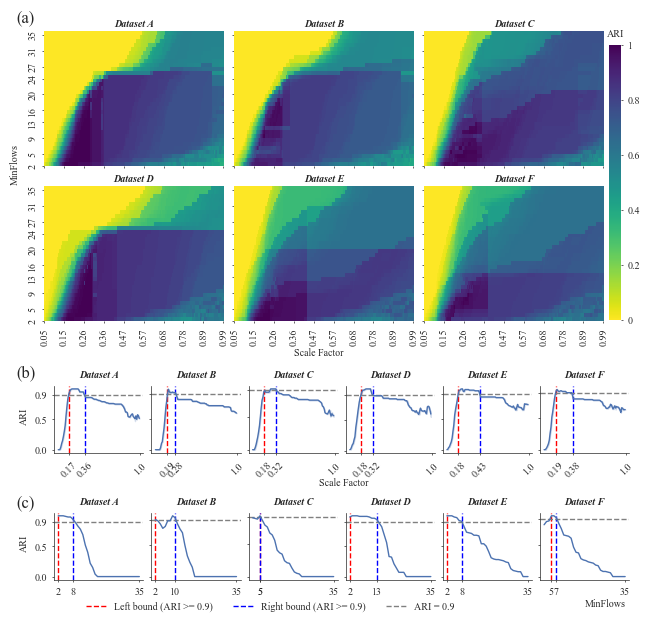

In [3]:
import matplotlib as mpl

fs1, ax1 = get_figsize_and_axes_sizeinfo(2, 3, twofigs_width_margin=0.1, height_width_ratio=0.75, twofigs_height_margin=0.2, right_margin=0.35) # 热力图
fs2, ax2 = get_figsize_and_axes_sizeinfo(1, 6, height_width_ratio=0.75, twofigs_width_margin=0.08, left_margin=0.2, top_margin=0.55) # scale factor的图
fs3, ax3 = get_figsize_and_axes_sizeinfo(1, 6, height_width_ratio=0.75, twofigs_width_margin=0.08, left_margin=0.2, top_margin=0.5) #minflows的图

fs, ax = figsize_sizeinfo_vstack(fs1, fs2, ax1, ax2, True)
fs, ax = figsize_sizeinfo_vstack(fs, fs3, ax, ax3, True)

fig, axes = get_fig_and_axes_from_sizeinfo(fs, ax)
# print(len(axes))
datasetnames = ["Dataset A", "Dataset B", "Dataset C", "Dataset D", "Dataset E", "Dataset F"]
minflows= [5, 9, 5, 5, 5, 5]
scalefactors = [0.2,0.2,0.19,0.24,0.23,0.21]

axes_iter = iter(axes)

draw_heatmap(df, next(axes_iter), "Dataset A", xtickslabel=False, ytickslabel=True)
draw_heatmap(df, next(axes_iter), "Dataset B", xtickslabel=False, ytickslabel=False)
draw_heatmap(df, next(axes_iter), "Dataset C", xtickslabel=False, ytickslabel=False)
draw_heatmap(df, next(axes_iter), "Dataset D", xtickslabel=True, ytickslabel=True)
draw_heatmap(df, next(axes_iter), "Dataset E", xtickslabel=True, ytickslabel=False)
draw_heatmap(df, next(axes_iter), "Dataset F", "ARI", xtickslabel=True, ytickslabel=False)

for i in range(6):
    ax = next(axes_iter)
    draw_scale_factor_sensitivity(df, ax, datasetnames[i], minflows[i])

for i in range(6):
    ax = next(axes_iter)
    draw_minflows_sensitivity(df, ax, datasetnames[i], scalefactors[i])

# 添加图例文字
fig.text(-0.03, 0.99, "(a)", fontsize=12)
fig.text(-0.03, 0.37, "(b)", fontsize=12)
fig.text(-0.03, 0.145, "(c)", fontsize=12)

fig.text(-0.04, 0.71, "MinFlows",rotation=90, fontsize=7.2)


fig.text(0.43, 0.407, "Scale Factor", fontsize=7.2)
fig.text(0.47, 0.182, "Scale Factor", fontsize=7.2)

fig.text(-0.025, 0.291, "ARI",rotation=90, fontsize=7.2)
fig.text(-0.025, 0.07, "ARI",rotation=90, fontsize=7.2)
fig.text(0.91, -0.03, "MinFlows", fontsize=7.2)

legend_lines = [
    Line2D([0], [0], color='red', linestyle='--', lw=1, label="Left bound (ARI >= 0.9)"),
    Line2D([0], [0], color='blue', linestyle='--', lw=1, label="Right bound (ARI >= 0.9)"),
    Line2D([0], [0], color='grey', linestyle='--', lw=1, label="ARI = 0.9"),
]

# 使用 fig.legend 手动放置图例
fig.legend(handles=legend_lines, loc="center", ncol=3, bbox_to_anchor=(0.39, -0.03), frameon=False)

# 创建一个横向的 colorbar 在整个 figure 顶部
# cbar_ax = fig.add_axes([0.2, 1.025, 0.5, 0.01])  # [左, 下, 宽, 高]
cbar_ax = fig.add_axes([0.95, 0.47, 0.02, 0.48])  # [左, 下, 宽, 高]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
# 显示横向 colorbar，并设置其位置在顶部
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical",shrink=0.2)
cbar.ax.text(0.51, 1.02, 'ARI', va='bottom', ha='center', transform=cbar.ax.transAxes, rotation=0)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
cbar.ax.xaxis.set_ticks_position('top')
cbar_ax.tick_params(width=.5, length=1.5)
for spine in cbar_ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
# fig.savefig("Fig/Fig9.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig9.svg", bbox_inches='tight')
plt.show()

## 6-Draw the adaption results of scale factor and MinFlows

This section draw the adaption results of scale factor and MinFlows.

In [4]:
def _k_distribution_function(k: int):
    k_value = k * math.factorial(2 * k) * (math.pi**0.5) / (((2**k) * math.factorial(k)) ** 2)
    return k_value

def _calculate_theory_ratio_value(k_range: Iterable) -> np.ndarray:
    k_range = list(k_range)
    ratio_values = list()
    for i in k_range:
        true_value = i
        ratio_value = (true_value + 1 - ((2 * true_value + 1) / (2 * true_value)) ** 2 * _k_distribution_function(true_value) ** 2) / (
            true_value - _k_distribution_function(true_value) ** 2
        )
        ratio_values.append(ratio_value)
    return np.asarray(ratio_values)

def _calculate_real_ratio_value(OD, k_range: Iterable, flow_distance_func: Callable) -> np.ndarray:
    k_dis = flow_kth_nearest_neighbor_distance(OD, k_range, return_index=False, flow_distance_func=flow_distance_func)  # noqa: F405
    v = np.var(k_dis, axis=0)
    return v[1:] / (v[:-1] + 1e-10)


# 基于K阶距离决定K
# [k_low, k_high]
def _calc_RKD(OD: np.ndarray, k_low, k_high, flow_distance_func) -> int:
    theory_rtv = _calculate_theory_ratio_value(range(k_low, k_high + 1))
    real_rtv = _calculate_real_ratio_value(OD, range(k_low, k_high + 2), flow_distance_func)
    assert len(theory_rtv) == len(real_rtv), "theory_rtv and real_rtv must have the same length"
    RKD = real_rtv / (theory_rtv + 1e-10)
    return RKD



In [5]:

def draw_k_value(ax, name, max_k, highlight_k, yticks=False, xticklabel=True):
    filepath = f'./data/Data{name}.txt'
    OD = np.loadtxt(filepath, delimiter=',')
    RKD = _calc_RKD(OD, 2, max_k, flow_distance_matrix_max_euclidean)
    highlight_rkd = RKD[highlight_k - 2]
    ax.plot(range(2, max_k+1), RKD, 'r-', lw=1.)
    ax.plot(highlight_k, highlight_rkd, 'b*', markersize=5, label=f'{highlight_k}')
    ax.set_xticks([5, 10, 15, 20])
    ax.set_yticks([1.00,1.05, 1.10, 1.15, 1.20])
    ax.legend(loc='best', frameon=False, labelspacing=0.5, handletextpad=0.1)
    ax.set_xlabel("")
    ax.set_ylabel('')
    if yticks:
        ax.set_ylabel("RKD")
    else:
        ax.set_yticklabels([])
        
    ax.tick_params(axis='both', width=.5, length=1.5,)
    # 设置标题
    ax.set_title(f"Dataset {name}", fontweight='bold', fontstyle='italic')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not xticklabel:
        ax.set_xticklabels([])


def draw_all_k_values(axes):
    assert len(axes) == 6
    names, ks = "ABCDEF", [7, 7, 5, 8, 8, 6]
    for i, ax in enumerate(axes):
        yticks = (i == 0)
        draw_k_value(ax, names[i], 20, ks[i], yticks)


def draw_each_scale_factor(df, ax, name, yticks=False):
    data = df[df['Dataset'] == name]
    # print(data)
    # break
    y = data["Estimated Scale Factor"]
    x = list(range(len(y)))
    ev = data["Elbow Value"].iloc[0]
    rv = data["Real Value"].iloc[0]
    evi = data["Elbow Index"].iloc[0]
    # print(y)
    # print(len(x))
    ax = sns.lineplot(x=x, y="Estimated Scale Factor", data=data, ax=ax, lw=1.)
    # ax.axhline(y=ev, color='r', linestyle='--', marker=".", markersize=8, lw=1., label=f'{ev:.2f}')
    # ax.axhline(y=rv, color='g', linestyle='--', lw=1., label=f'{rv:.2f}')
    # ax.axvline(x=evi, color='y', linestyle='--', lw=1.)
    # 绘制红色虚线（ev）到交点
    ax.plot([0, evi], [ev, ev], color='r', linestyle='-.', lw=1., label=f'{ev:.2f}')
    ax.plot([evi, evi], [0, ev], color='y', linestyle='--', lw=1.)
    # 绘制绿色虚线（rv）到交点
    ax.plot([0, evi], [rv, rv], color='g', linestyle='-.', lw=1., label=f'{rv:.2f}')
    # 去掉顶部和右侧的边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel("")
    ax.set_ylabel('')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticks([evi])
    ax.legend(loc="best", frameon=False)
    if yticks:
        # ax.set_yticks([1.00, 1.05, 1.10, 1.15, 1.20])
        ax.set_ylabel("Scale Factor")
    else:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', width=.5, length=1.5,)
    # 设置标题
    ax.set_title(f"{name}", fontweight='bold', fontstyle='italic')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    
def draw_all_scale_factors(axes):
    """draw all scale factors"""
    df = pd.read_csv("./result/adaption_results.csv")
    names = "ABCDEF"
    for i in range(len(axes)):
        name = names[i]
        yticks = i == 0
        draw_each_scale_factor(df, axes[i], f"Dataset {name}", yticks)

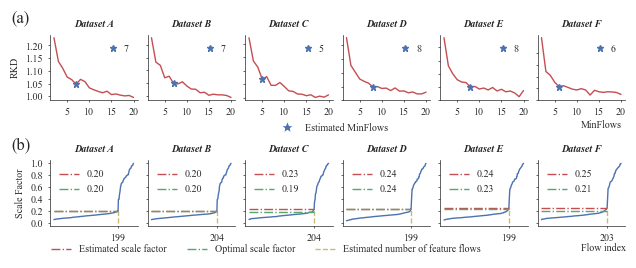

In [6]:
fig1, sizeinfo1 = get_figsize_and_axes_sizeinfo(1, 6, height_width_ratio=0.75, left_margin=0.2, twofigs_width_margin=0.1, twofigs_height_margin=0.4)

fig2, sizeinfo2 = get_figsize_and_axes_sizeinfo(1, 6, height_width_ratio=0.75, left_margin=0.2, twofigs_width_margin=0.1, twofigs_height_margin=0.3, top_margin=0.5)

fg, sizeinfo = figsize_sizeinfo_vstack(fig1, fig2, sizeinfo1, sizeinfo2, merge_ax=True)
fig, axes = get_fig_and_axes_from_sizeinfo(fg, sizeinfo)
draw_all_k_values(axes[:6])
draw_all_scale_factors(axes[6:])

fig.text(-0.03, 0.99, "(a)", fontsize=12)
fig.text(-0.03, 0.4, "(b)", fontsize=12)

fig.text(0.91, 0.50, "MinFlows", fontsize=7.2)
fig.text(0.91, -0.07, "Flow index", fontsize=7.2)

custom_legend = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', markersize=10, label='Estimated MinFlows')]

fig.legend(handles=custom_legend, loc='center', bbox_to_anchor=(0.5, 0.50), ncol=1, frameon=False)


legend_lines = [Line2D([0], [0], color='r', linestyle='-.', lw=1., label='Estimated scale factor'), 
                Line2D([0], [0], color='g', linestyle='-.', lw=1., label='Optimal scale factor'), Line2D([0], [0], color='y', linestyle='--', lw=1., label='Estimated number of feature flows')
                ]

# 添加图例，放置在图的最上方
fig.legend(handles=legend_lines, loc='center', bbox_to_anchor=(0.39, -0.06), ncol=3, frameon=False)
# fig.savefig("Fig/Fig10.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig10.svg", bbox_inches='tight')
plt.show()

## 7-Draw result of time complexity analysis

This section will draw the result of time complexity analysis, includes the time complexity of the four algorithms on datasets with varying size, the time-consuming of each stage, and the comparison of parallel and sequential.

In [7]:


def plot_time_complexity_small_scale(dirpath="./output/csv", ax=None, prefix='time-complexity-500-5000-100'):
    # 获取文件列表，过滤出前缀符合要求的文件
    files = sorted([f for f in os.listdir(dirpath) if f.startswith(prefix)])[:10]

    # 读取数据并合并
    data_frames = []
    for file in files:
        file_path = os.path.join(dirpath, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)
    data = pd.concat(data_frames)

    # 计算平均值和置信区间
    data_grouped = data.groupby(['DataSize', 'Algorithm']).agg(
        mean_time=('Time', 'mean'),
        sem_time=('Time', 'sem')  # 标准误差
    ).reset_index()
    
    # 计算置信区间
    data_grouped['ci95_hi'] = data_grouped['mean_time'] + 1.96 * data_grouped['sem_time']
    data_grouped['ci95_lo'] = data_grouped['mean_time'] - 1.96 * data_grouped['sem_time']
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    ax.set_ylabel('Log(Runtime) (s)')

    ax.set_xlabel('Data Size', loc='center')
    ii = -1
    # 绘制
    for algorithm in data_grouped['Algorithm'].unique():
        ii += 1
        subset = data_grouped[data_grouped['Algorithm'] == algorithm]
        # 取对数
        log_mean_time = np.log10(subset['mean_time'])
        log_ci95_lo = np.log10(subset['ci95_lo'])
        log_ci95_hi = np.log10(subset['ci95_hi'])
        
        # 绘制置信区间
        ax.fill_between(subset['DataSize'], 
                        log_ci95_lo,
                        log_ci95_hi,
                        alpha=0.15, color=colors[ii])  # 透明度调整为0.15

        # 拟合直线
        coeffs = np.polyfit(subset['DataSize'], log_mean_time, 1)
        poly = np.poly1d(coeffs)
        ax.plot(subset['DataSize'], poly(subset['DataSize']), label=algorithm, c=colors[ii], lw=1)

        # 绘制原始数据点，颜色与线条一致
        ax.scatter(subset['DataSize'], log_mean_time, s=3, c=colors[ii])  # 点的大小调整为5

    # 设置标签和标题
    ax.set_title('')

    # 设置纵坐标标签为原始时间值，不使用科学计数法
    y_ticks = ax.get_yticks()
    ax.set_yticklabels([f'{10**y:.2f}' for y in y_ticks])
    
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='both', width=0.5, length=1.5, colors='black', direction='in')
    ax.legend(loc='best', ncol=2, frameon=False )


def plot_time_complexity_large_scale(dirpath="./output/csv", ax=None, prefix='time-complexity-5500-20000-500'):
    # 获取文件列表，过滤出前缀符合要求的文件
    files = sorted([f for f in os.listdir(dirpath) if f.startswith(prefix)])[:10]

    # 读取数据并合并
    data_frames = []
    for file in files:
        file_path = os.path.join(dirpath, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)
    data = pd.concat(data_frames)

    # 计算平均值和置信区间
    data_grouped = data.groupby(['DataSize', 'Algorithm']).agg(
        mean_time=('Time', 'mean'),
        sem_time=('Time', 'sem')  # 标准误差
    ).reset_index()
    
    # 计算置信区间
    data_grouped['ci95_hi'] = data_grouped['mean_time'] + 1.96 * data_grouped['sem_time']
    data_grouped['ci95_lo'] = data_grouped['mean_time'] - 1.96 * data_grouped['sem_time']
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    ax.set_ylabel('')
    ax.set_xlabel('Data Size', loc='center')
    
    ii = -1
    # 绘制
    for algorithm in data_grouped['Algorithm'].unique():
        ii += 1
        subset = data_grouped[data_grouped['Algorithm'] == algorithm]
        # 取对数
        log_mean_time = np.log10(subset['mean_time'])
        log_ci95_lo = np.log10(subset['ci95_lo'])
        log_ci95_hi = np.log10(subset['ci95_hi'])
        
        # 绘制置信区间
        ax.fill_between(subset['DataSize'], 
                        log_ci95_lo,
                        log_ci95_hi,
                        alpha=0.15, color=colors[ii])  # 透明度调整为0.15

        # 拟合直线
        coeffs = np.polyfit(subset['DataSize'], log_mean_time, 1)
        poly = np.poly1d(coeffs)
        ax.plot(subset['DataSize'], poly(subset['DataSize']), label=algorithm, c=colors[ii], lw=1)

        # 绘制原始数据点，颜色与线条一致
        ax.scatter(subset['DataSize'], log_mean_time, s=3, c=colors[ii])  # 点的大小调整为5

    # 设置标签和标题
    ax.set_title('')

    # 设置纵坐标标签为原始时间值，不使用科学计数法
    y_ticks = ax.get_yticks()
    ax.set_yticklabels([f'{10**y:.2f}' for y in y_ticks])
    
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.legend(loc='lower right', ncol=2, frameon=False )



def plot_runtime_distribution_stacked(ax, color_palette='pastel'):
    df = pd.read_csv("./result/ScaleFC_each_step_time.csv")
    # 数据预处理
    df_melted = df.melt(id_vars='Dataset', value_vars=['S1', 'S2', 'S3', 'S4'],
                        var_name='Stage', value_name='Runtime')
    df_summary = df_melted.groupby(['Dataset', 'Stage']).agg(
        avg_runtime=('Runtime', 'mean')
    ).reset_index()
    
    # 计算每个阶段的时间占比
    df_total = df.groupby('Dataset')['Total'].mean().reset_index()
    df_summary = df_summary.merge(df_total, on='Dataset')
    df_summary['runtime_ratio'] = df_summary['avg_runtime'] / df_summary['Total']
    
    # 绘制堆叠柱状图
    datasets = df_summary['Dataset'].unique()
    bottom = np.zeros(len(datasets))  # 初始化每个数据集的底部位置
    unique_stages = df_summary['Stage'].unique()
    
    for stage in unique_stages:
        stage_data = df_summary[df_summary['Stage'] == stage]
        
        # 堆叠柱状图
        bars = ax.bar(stage_data['Dataset'], stage_data['runtime_ratio'], label=stage, 
                      bottom=bottom, color=sns.color_palette(color_palette)[list(unique_stages).index(stage)])
        
        # 在柱子内添加百分比标注（大于0.1%的才显示）
        for bar, percent in zip(bars, stage_data['runtime_ratio']):
            if percent * 100 >= 0.1:  # 仅显示大于0.1%的值
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    bar.get_y() + height / 2,
                    f"{percent * 100:.2f}%", 
                    ha='center', va='center', color='black', fontsize=7.2
                )
        
        # 更新底部位置
        bottom += stage_data['runtime_ratio'].values  # 使用 .values 保证数组大小匹配
    
    # 设置图形美化
    ax.set_title("")
    ax.set_xlabel("Dataset", fontstyle='italic', fontweight='bold')
    
    ax.set_yticklabels([])
    ax.set_ylabel("Runtime Proportion", labelpad=1)
    ax.set_xticklabels(list("ABCDEF"))
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
        label.set_fontstyle('italic')

    
    # 设置图例在顶部，横向排列，每行四个，并留出上方空间避免压盖
    ax.legend(title="", loc='upper center', bbox_to_anchor=(0.5, 1.12),
              ncol=4, frameon=False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def draw_speedup(ax1):
    df = pd.read_csv("./result/ScaleFC-para-nonpara-time.csv")
    df['Speedup'] = df['TimeNone'] / df['TimePara']

    bar_width = 0.35
    index = np.arange(len(df['Dataset']))

    _ = ax1.bar(index, df['TimeNone'], bar_width, label='Sequential', color='green')
    _ = ax1.bar(index + bar_width, df['TimePara'], bar_width, label='Parallel', color='orange')

    ax2 = ax1.twinx()
    ax2.set_ylabel('')
    ax2.set_yticks([])
    
    used_color = '#d62728'
    line, = ax2.plot(index + bar_width / 2, df['Speedup'], color=used_color, linewidth=1, marker='o', label='Speedup', markersize=2, linestyle='--')

    for i in range(len(df)):
        x = index[i] + bar_width / 2
        y = df['Speedup'][i]
        offset_y = 0.2
        offset_x = 0
        va = 'bottom'
        
        # 自适应调整标注位置
        if i == 0:
            offset_y = 1.5  # A和B需要更高的偏移量
            offset_x = -0.05
        elif i == 1:
            offset_y = 1.2  # A和B需要更高的偏移量
            offset_x = -0.05
        elif i == 4:
            offset_y = -0.2  # E需要向下
            va = 'top'
        elif i == 5:
            offset_x = -0.6
            offset_y=-0.2
        
        ax2.text(x + offset_x, y + offset_y, f'{y:.2f}', ha='center', va=va, color=used_color)

    ax1.set_xlabel('')
    ax1.set_ylabel('Runtime (s)', labelpad=1)
    ax1.set_title('')
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(list("ABCDEF"))
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')
        label.set_fontstyle('italic')
    
    # 合并图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, ncol=1, loc='upper left', frameon=False)

    ax2.tick_params(axis='both', width=0.5, length=1.5)
    for spine in ax2.spines.values():
        spine.set_linewidth(0.)
        
    ax1.set_xlabel("Dataset", fontstyle='italic', fontweight='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

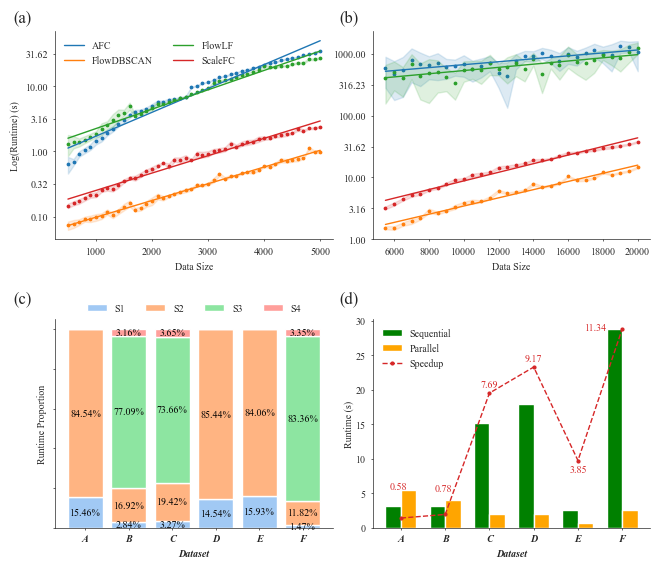

In [9]:

# 示例用法
fig2, sizeinfo2 = get_figsize_and_axes_sizeinfo(2, 2, height_width_ratio=0.75, left_margin=0, twofigs_width_margin=0.40, twofigs_height_margin=0.8)
fig, axes = get_fig_and_axes_from_sizeinfo(fig2, sizeinfo2)

for ax in axes:
    ax.tick_params(axis='both', width=.5, length=1.5,)

plot_time_complexity_small_scale(ax=axes[0],dirpath='./result/')
plot_time_complexity_large_scale(dirpath='./result/', ax=axes[1], prefix='time-complexity-5500-20000-500')
plot_runtime_distribution_stacked(ax=axes[2])
fig.text(-0.07, 0.99, "(a)", fontsize=12)
fig.text(0.47, 0.99, "(b)", fontsize=12)
fig.text(-0.07, 0.45, "(c)", fontsize=12)
fig.text(0.47, 0.45, "(d)", fontsize=12)

draw_speedup(axes[3])
# fig.savefig("Fig11.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig11.svg", bbox_inches='tight')
plt.show()

## 8-Draw result of supplementary experiments

To draw the results of the supplementary experiments, including combining FlowDBSCAN, FlowLF, and the scale factor, as well as comparing them with the distances defined in Tao (2016/2019), and examine the comparative experimental results.

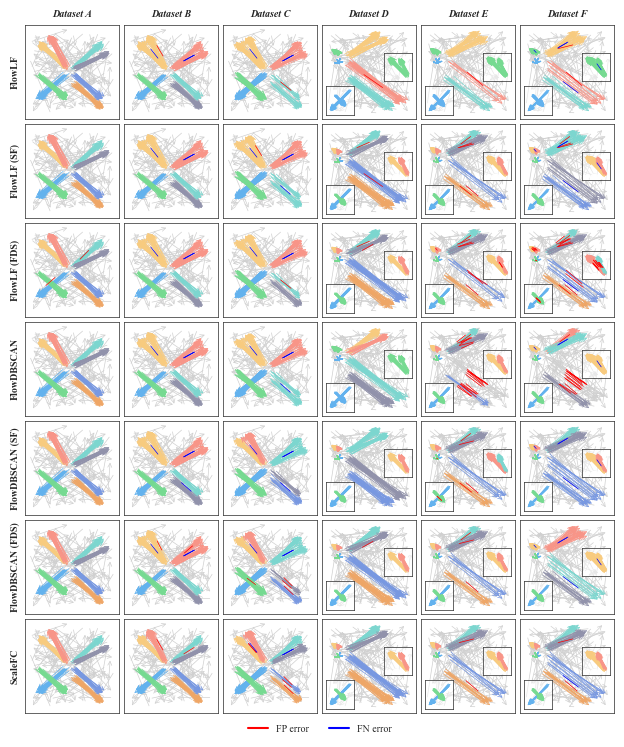

In [ ]:
def get_fig_and_axes(row_num, col_num, A4_width=6.05):
    # 整个大图的边缘
    left_margin = 0.08
    right_margin = 0.08
    bottom_margin = 0.08
    top_margin = 0.15

    twofigs_margin = 0.05

    # 8.27是A4的宽度，单位英寸
    sf_size = (A4_width - right_margin - left_margin - twofigs_margin * (col_num - 1)) / col_num
    sf_size = math.floor(sf_size * 100) / 100

    figsize = (left_margin + right_margin + col_num * sf_size + (col_num - 1) * twofigs_margin, 
            row_num * sf_size + bottom_margin + top_margin + (row_num - 1) * twofigs_margin)


    # 根据0,0计算出坐标的大小
    func = lambda a, b: ((left_margin + b * (sf_size + twofigs_margin))/figsize[0], 
                (bottom_margin + (row_num - 1 - a) * (sf_size + twofigs_margin))/ figsize[1], 
                sf_size / figsize[0] ,
                sf_size / figsize[1])

    # 创建数组
    # print(figsize)
    axes = np.empty((row_num, col_num), dtype=object)
    fig = plt.figure(figsize=figsize)
    for a in range(row_num):
        for b in range(col_num):
            cur_ax = fig.add_axes(func(a, b))
            # cur_ax.scatter(0, 0)
            axes[a, b] = cur_ax
            for spine in cur_ax.spines.values():
                spine.set_linewidth(0.5)  # 粗细，可以根据需要调整 

    return fig, axes


def str_to_array(s):
    import re
    return np.array([int(x) for x in re.findall(r'-?\d+', s)])
df = pd.read_csv('result/synthetic_clustering_resuls_with_sf_and_Tao_dis.csv', converters={'RealLabel': str_to_array, 'PredLabel': str_to_array})

newrow_num = 7
newcol_num = 6
fig, axs = get_fig_and_axes(newrow_num, newcol_num)

# 确保数据量不超过图的容量
data_df = df.iloc[:newrow_num * newcol_num]

index = -1
for _, row in data_df.iterrows():
    index += 1
    name = row['DataName'].split()[1]
    OD = ODS[name]
    pred_label = row["PredLabel"]
    real_label = row["RealLabel"]
    cur_ax = axs[index % newrow_num, index // newrow_num]
    inset = False
    if row["DataName"] in ("Dataset D", "Dataset E", "Dataset F"):
        inset = True
    flow_draw_cluster_fp_fn_error_by_lines2(
        OD, real_label, pred_label,
        draw_cluster_with_label_kwargs=dict(color_generator='feature', title="", new_color_gen=True, ax=cur_ax, lw=0.5, noise_flow_color="#d0d0d0"),
        fn_line_kwargs={'color': 'red', 'zorder': 9, "lw": 0.5},
        fp_line_kwargs={'color': 'blue', 'zorder': 9, "lw": 0.5},
        draw_inset=inset
    )
    
    if index % newrow_num == 0:
        cur_ax.set_title(row['DataName'], fontweight='bold', fontstyle='italic')
    if index // newrow_num == 0:
        cur_ax.set_ylabel(row['AlgoName'], fontweight='bold')
    
    for spine in cur_ax.spines.values():
        spine.set_linewidth(0.5)  # 粗细，可以根据需要调整

# 单独处理图例
legend_handles = [
    Line2D([0], [0], color="red", lw=1.5, label="FP error"),
    Line2D([0], [0], color="blue", lw=1.5, label="FN error")
]
fig.legend(handles=legend_handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.03), frameon=False)
plt.tight_layout()
# fig.savefig("Fig/Fig-t1.png", bbox_inches='tight', dpi=600)
# fig.savefig("Fig/Fig-t1.svg", bbox_inches='tight')
plt.show()
# plt.close()

